In [2]:
from PIL import Image
import glob
import cv2
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense, Dropout, Flatten
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
%matplotlib inline

/home/tetsu/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tetsu/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


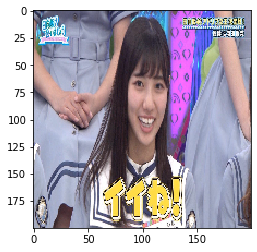

In [3]:
image_size = 200
image = Image.open('./images/hina/000035.JPG')
image = image.convert("RGB")
image = image.resize((image_size, image_size))
data = np.asarray(image)
plt.imshow(data)

In [4]:
folder = ["after_hina","after_tetsu"]
for index,name in enumerate(folder):
    dir = "./images/after/" + name
    files = glob.glob(dir + "/*.JPG")
    print(name, len(files), )

after_hina 65
after_tetsu 65


In [5]:
def cropping(img, x, y, w, h):
    #(x, y),(x+px, y),(x,y+px),(x+px, y+px)を四隅としてcrop
    cropped = img[y:y+h,x:x+w]
    #サイズを拡大　
    cropped = cv2.resize(cropped, (image_size, image_size))
    return cropped

In [6]:
def face_search(image):
    #顔
    face_cascade_path = "haarcascade_frontalface_alt.xml"
    # カスケード分類器を作成
    face_cascade = cv2.CascadeClassifier(face_cascade_path) 

    # 画像を読み込む
    img = cv2.imread(image) 
    # グレースケール化
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 


    # 出力結果用にコピー & BGR化
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    #顔を検知
    faces = face_cascade.detectMultiScale(img_gray)
    
    if len(faces) == 1:
        for (x,y,w,h) in faces:
            print((x,y,w,h))
            img = cropping(img, x, y, w, h)
        return img
    else :
        print("認識失敗", image)
        return img

In [7]:
face_search("./images/hina/000008.JPG").shape

(243, 73, 149, 149)


(200, 200, 3)

In [8]:
# # 顔を切り抜いて保存
# savefolder = ["after_hina", "after_tetsu"]
# for index, name in enumerate(folder):
#     dir = "./images/" + name
#     files = glob.glob(dir + "/*.JPG")
#     for i, file in enumerate(files):
#         _image = face_search(file)
#         cv2.imwrite("./images/" + savefolder[index] + "/" + str(i) + ".JPG", _image)

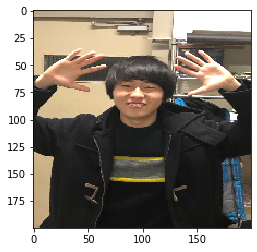

In [9]:
X = []
Y = []
for index, name in enumerate(folder):
    dir = "./images/after/" + name
    files = glob.glob(dir + "/*.JPG")
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        plt.imshow(data)
        X.append(data)
        Y.append(index)

X = np.array(X, dtype=np.uint8)
Y = np.array(Y, dtype=int)
Y = Y.reshape(-1,1)

In [10]:
print(X.shape)
print(Y.shape)

(130, 200, 200, 3)
(130, 1)


In [11]:
def flip(img):
    #左右反転
    flipped = cv2.flip(img, 1)
    return flipped

In [12]:
def gamma1(img):
    gamma = 0.75
    LUT_G1 = np.arange(256, dtype = 'uint8' )
    for i in range(256):
        LUT_G1[i] = 255 * pow(float(i) / 255, 1.0 / gamma)
    gamma_img = cv2.LUT(img, LUT_G1)
    return gamma_img

In [13]:
def gamma2(img):
    gamma = 1.5
    LUT_G2 = np.arange(256, dtype = 'uint8' )
    for i in range(256):
        LUT_G2[i] = 255 * pow(float(i) / 255, 1.0 / gamma)
    gamma_img = cv2.LUT(img, LUT_G2)
    return gamma_img

In [14]:
def noise(img):
    row,col,ch= img.shape
    mean = 0
    sigma = 15
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    gauss_img = img + gauss
    return gauss_img

In [15]:
def preprocess(X, y):
    new_X = np.ndarray((0, image_size,image_size, 3),dtype=np.uint8)
    new_y = np.ndarray((0),dtype=int)
    for index, img in enumerate(X):
        flipped = flip(img)
        _gamma1 = gamma1(flipped)
        _gamma2 = gamma2(flipped)
        noised = noise(flipped)

        new_X = np.concatenate([new_X,
                                flipped.reshape(1,image_size,image_size,3), 
                                _gamma1.reshape(1,image_size,image_size,3),
                                _gamma2.reshape(1,image_size,image_size,3),
                                noised.reshape(1,image_size,image_size,3)],
                                axis=0)
        new_y = np.concatenate([new_y,
                                y[index],
                                y[index],
                                y[index],
                                y[index]],
                               axis=0)

    #シャッフル
    cnt = new_X.shape[0]
    
    shuffle_array = np.arange(cnt)
    np.random.shuffle(shuffle_array)
    
    new_X = new_X[shuffle_array]
    new_y = new_y[shuffle_array]
    
    new_y = new_y.reshape(-1, 1)
            
    return new_X, new_y

In [16]:
X, Y = preprocess(X, Y)

In [17]:
X = X.astype('float32')
X = X / 255.0
print(X.shape)
print(Y.shape)

(520, 200, 200, 3)
(520, 1)


In [18]:
Y = np_utils.to_categorical(Y,len(folder))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)

In [20]:
print(len(X_train))
print(len(X_test))

364
156


In [21]:
input_shape = (image_size,image_size,3)
epochs = 5
batch_size = 15

In [22]:
# モデルの定義
model = Sequential()

## ２次元畳み込み層１ 
model.add(Conv2D(filters=32, activation='relu', input_shape=input_shape, kernel_size=(3, 3), strides=(1, 1), padding='same'))

## ２次元畳み込み層２ 
model.add(Conv2D(filters=64, activation='relu', kernel_size=(3, 3), strides=(1, 1), padding='same'))

## maxプーリング層 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
## 全結合層１ 
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.50))

## 全結合層２ 
model.add(Dense(len(folder), activation='softmax'))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 640000)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               163840256 
____

In [23]:
# コンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(), 
              metrics=['accuracy'])

In [24]:
# 学習
hist = model.fit(X_train,
                 y_train,
                 epochs=epochs,
                 validation_data=(X_test, y_test),
                 verbose=1,
                 batch_size=batch_size)

Train on 364 samples, validate on 156 samples
Epoch 1/5
364/364 [==============================] - 42s 114ms/sample - loss: 4.0689 - acc: 0.7967 - val_loss: 0.1102 - val_acc: 0.9679
Epoch 2/5
364/364 [==============================] - 41s 112ms/sample - loss: 0.1152 - acc: 0.9560 - val_loss: 0.0192 - val_acc: 1.0000
Epoch 3/5
364/364 [==============================] - 40s 111ms/sample - loss: 0.0144 - acc: 1.0000 - val_loss: 0.0118 - val_acc: 0.9936
Epoch 4/5
364/364 [==============================] - 41s 112ms/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 5/5
364/364 [==============================] - 40s 111ms/sample - loss: 2.2232e-04 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000


In [25]:
hist.history

{'loss': [4.068905591637224,
  0.11521085821716422,
  0.014390460994756002,
  0.001051862553537036,
  0.00022232103942101375],
 'acc': [0.7967033, 0.95604396, 1.0, 1.0, 1.0],
 'val_loss': [0.11016910036022846,
  0.019226555506555505,
  0.01182874668344224,
  0.0014225495394839527,
  0.0010315706584090268],
 'val_acc': [0.96794873, 1.0, 0.99358976, 1.0, 1.0]}

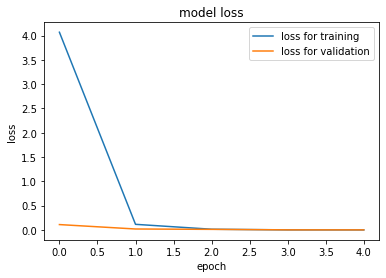

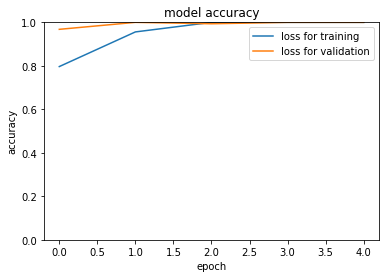

In [26]:
## 損失関数のグラフ(1点)
def plot_history_loss(hist):
    # hist.historyに辞書型で損失値や精度が入っているので取得して表示
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    
    #matplotlibの細かい設定
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    
    plt.show()
    

##　精度のグラフ(1点)
## tf2.0では'acc'ではなく'accuracy'なので注意
def plot_history_acc(hist):
    plt.plot(hist.history['acc'],label="loss for training")
    plt.plot(hist.history['val_acc'],label="loss for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.show()

plot_history_loss(hist)
plot_history_acc(hist)

In [27]:
#評価 & 評価結果出力
print(model.evaluate(X_test, y_test))

156/156 [==============================] - 3s 16ms/sample - loss: 0.0010 - acc: 1.0000
[0.0010315706978219214, 1.0]


In [28]:
# モデルの保存
open('and.json',"w").write(model.to_json())

# 学習済みの重みを保存
model.save_weights('and_weight.hdf5')